Design MERFISH probes using the example inputs from Jeff Moffitt. The original MATLAB design pipeline can be found at https://github.com/ZhuangLab/MERFISH_analysis.

# Prepare inputs

In [ ]:
# Download the input data
# This is for the UNIX-like operating systems. If you are using Windows, just download the files accordingly.
!mkdir temporary_data
!wget http://zhuang.harvard.edu/merfish/MERFISHData/MERFISH_Examples2.zip -O temporary_data/MERFISH_Examples2.zip
!unzip temporary_data/MERFISH_Examples2.zip -d temporary_data -o
# Make a path for output
!mkdir temporary_data/MERFISH_Examples2/outputs

In [1]:
# Define all the input files you need in this script
codebook_file = 'temporary_data/MERFISH_Examples2/codebook.csv'
transcripts_fasta_file = 'temporary_data/MERFISH_Examples2/transcripts.fasta'
fpkm_tracking_file = 'temporary_data/MERFISH_Examples2/isoforms.fpkm_tracking'
readout_fasta_file = 'temporary_data/MERFISH_Examples2/readouts.fasta'
forward_primer_file = 'data/forward_primers.fasta'
reverse_primer_file = 'data/reverse_primers.fasta'
ncRNA_file = 'temporary_data/MERFISH_Examples2/Homo_sapiens.GRCh38.ncrna.fa'

# Define the output files
ottable_transcriptome_file = 'temporary_data/MERFISH_Examples2/outputs/ottable_transcriptome.pkl'

# Initialize data structures

In [2]:
# Import the modules
import os
import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as pd
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot

In [3]:
# Load the transcriptome as a pandas data frame
# Make sure that the transcriptome data frame has the standard column names!
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name, FPKM
transcriptome = fio.load_transcriptome(transcripts_fasta_file, fpkm_tracking_file)
transcriptome # Let's have a look at what's inside the transcriptome

Loaded 198798 transcripts.
Loaded FPKMs for 215942 transcripts of 66008 genes.
Kept 198664 transcripts of 60655 genes after merging.


,transcript_id,description,sequence,class_code,nearest_ref_id,gene_id,gene_short_name,tss_id,locus,length,coverage,FPKM,FPKM_conf_lo,FPKM_conf_hi,FPKM_status
0,ENST00000456328.2,ENST00000456328.2 gene=DDX11L1,GTTAACTTGCCGTCAGCCTTTTCTTTGACCTCTTCTTTCTGTTCAT...,-,-,ENSG00000223972.5,DDX11L1,TSS55016,chr1:11868-14409,1657,0.256513,1.249310,0.452708,2.04591,OK
1,ENST00000450305.2,ENST00000450305.2 gene=DDX11L1,GTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGGTGCAAGCTG...,-,-,ENSG00000223972.5,DDX11L1,TSS192742,chr1:12009-13670,632,0.093602,0.455876,0.000000,1.51329,OK
2,ENST00000488147.1,ENST00000488147.1 gene=WASH7P,ATGGGAGCCGTGTGCACGTCGGGAGCTCGGAGTGAGCGCACCATGA...,-,-,ENSG00000227232.5,WASH7P,TSS157056,chr1:14403-29570,1351,1.449420,7.059220,5.016000,9.10244,OK
3,ENST00000619216.1,ENST00000619216.1 gene=MIR6859-1,TGTGGGAGAGGAACATGGGCTCAGGACAGCGGGTGTCAGCTTGCCT...,-,-,ENSG00000278267.1,MIR6859-1,TSS184916,chr1:17368-17436,68,15.689100,76.411500,0.000000,646.95000,OK
4,ENST00000473358.1,ENST00000473358.1 gene=RP11-34P13.3,GTGCACACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCGCCCC...,-,-,ENSG00000243485.3,RP11-34P13.3,TSS170288,chr1:29553-31097,712,0.126199,0.614633,0.000000,1.50615,OK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198659,ENSTR0000483079.5,ENSTR0000483079.5 gene=WASH6P,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,-,-,ENSGR0000182484.14,WASH6P,TSS112404,chrY:57209305-57210051,658,0.000000,0.000000,0.000000,0.00000,OK
198660,ENSTR0000496301.5,ENSTR0000496301.5 gene=WASH6P,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,-,-,ENSGR0000182484.14,WASH6P,TSS35569,chrY:57209886-57212186,1641,0.000000,0.000000,0.000000,0.00000,OK
198661,ENSTR0000483286.5,ENSTR0000483286.5 gene=WASH6P,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,-,-,ENSGR0000182484.14,WASH6P,TSS7948,chrY:57210343-57212074,832,0.000000,0.000000,0.000000,0.00000,OK
198662,ENSTR0000464205.5,ENSTR0000464205.5 gene=WASH6P,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,-,-,ENSGR0000182484.14,WASH6P,TSS15231,chrY:57210590-57212074,534,0.000000,0.000000,0.000000,0.00000,OK


In [4]:
# Load the codebook
cb_version, cb_name, bit_names, barcode_table = fio.load_merlin_codebook(codebook_file)
gene_ids = list(barcode_table['name'][barcode_table['id'] != '']) # Get the non-blank gene names
transcript_ids = set(barcode_table['id'][barcode_table['id'] != '']) # Get the non-blank transcript ids
barcode_table # Let's have a look at the barcode table

,name,id,barcode_str
0,Blank-1,,0011100000001000
1,Blank-10,,1001100100000000
2,Blank-2,,0011000100100000
3,Blank-3,,0011010001000000
4,Blank-4,,0010010000001100
...,...,...,...
135,AGAP1,ENST00000614409.4,0000001001100001
136,XKR5,ENST00000618990.4,0100001000100010
137,FBN2,ENST00000619499.4,0000001101000100
138,RP4-671O14.6,ENST00000624919.1,0100000100110000


In [5]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = pd.init_probe_dict(gene_ids, transcriptome, 'gene_short_name', K=30)
pd.print_probe_dict(probe_dict)

Found 943 transcripts for 130 target genes.
Gene	Transcript	N_probes
VPS13D
	ENST00000613099.4	16216
	ENST00000620676.4	16291
	ENST00000476169.1	446
	ENST00000489961.1	414
	ENST00000011700.10	10940
	ENST00000460333.5	4881
	ENST00000487188.1	3961
	ENST00000469054.1	538
	ENST00000543710.5	5647
	ENST00000466732.2	348
	ENST00000476045.5	351
	ENST00000481484.1	331
	ENST00000543766.2	3809
	ENST00000473099.1	432
PRDM2
	ENST00000484063.6	599
	ENST00000376048.9	2659
	ENST00000311066.9	7408
	ENST00000235372.11	7928
	ENST00000491134.5	1071
	ENST00000502727.5	553
	ENST00000502724.5	512
	ENST00000413440.5	6146
	ENST00000343137.8	5768
	ENST00000491815.1	629
	ENST00000503842.5	676
	ENST00000407521.7	484
	ENST00000505823.5	539
	ENST00000487453.1	617
LUZP1
	ENST00000418342.5	8392
	ENST00000302291.8	8869
	ENST00000314174.5	3686
	ENST00000471849.5	1161
	ENST00000475164.2	584
CNR2
	ENST00000374472.4	5225
AHDC1
	ENST00000247087.9	6305
	ENST00000374011.6	6409
	ENST00000487743.2	388
	ENST00000490295.1	482
	E

In [6]:
# The probe_dict is just a dictionary of dictionary of pandas data frames.
# Let's have a look at the data frame of an example transcript.
probe_dict['VPS13D']['ENST00000613099.4']

,gene_id,transcript_id,shift,target_sequence
0,VPS13D,ENST00000613099.4,0,GGAGGAAACGCCGCGCAGCGCCGGGCTGGG
1,VPS13D,ENST00000613099.4,1,GAGGAAACGCCGCGCAGCGCCGGGCTGGGG
2,VPS13D,ENST00000613099.4,2,AGGAAACGCCGCGCAGCGCCGGGCTGGGGC
3,VPS13D,ENST00000613099.4,3,GGAAACGCCGCGCAGCGCCGGGCTGGGGCG
4,VPS13D,ENST00000613099.4,4,GAAACGCCGCGCAGCGCCGGGCTGGGGCGG
...,...,...,...,...
16211,VPS13D,ENST00000613099.4,16211,CCTGTGGAATAAAATGCCTTGTGGACTTCC
16212,VPS13D,ENST00000613099.4,16212,CTGTGGAATAAAATGCCTTGTGGACTTCCC
16213,VPS13D,ENST00000613099.4,16213,TGTGGAATAAAATGCCTTGTGGACTTCCCA
16214,VPS13D,ENST00000613099.4,16214,GTGGAATAAAATGCCTTGTGGACTTCCCAA


In [7]:
# Select the transcripts that we want to target
# The target transcripts are already defined in the codebook
probe_dict = pd.select_transcripts_by_ids(probe_dict, transcript_ids)
pd.print_probe_dict(probe_dict) # We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
VPS13D
	ENST00000613099.4	16216
PRDM2
	ENST00000343137.8	5768
LUZP1
	ENST00000418342.5	8392
CNR2
	ENST00000374472.4	5225
AHDC1
	ENST00000374011.6	6409
AGO3
	ENST00000373191.8	19658
RAB3B
	ENST00000371655.3	12815
USP24
	ENST00000294383.6	10520
MAN1A2
	ENST00000356554.7	8547
NOTCH2
	ENST00000256646.6	11360
TPR
	ENST00000367478.8	9679
PLXNA2
	ENST00000367033.3	11415
DIEXF
	ENST00000491415.6	8417
PTPN14
	ENST00000366956.9	12956
CENPF
	ENST00000366955.7	10278
FAM208B
	ENST00000328090.9	8597
KIAA1462
	ENST00000375377.1	9236
CHST3
	ENST00000373115.4	6941
RBM20
	ENST00000369519.3	7204
BUB3
	ENST00000368865.8	7799
CKAP5
	ENST00000312055.9	6503
MALAT1
	ENST00000534336.1	8679
RNF169
	ENST00000299563.4	7794
FZD4
	ENST00000531380.1	7354
AMOTL1
	ENST00000433060.2	8941
CBL
	ENST00000264033.4	11436
ITPR2
	ENST00000381340.7	11376
SLC38A1
	ENST00000398637.9	8037
DIP2B
	ENST00000301180.9	8564
CBX5
	ENST00000209875.8	11499
ANKRD52
	ENST00000267116.7	8659
LRP1
	ENST00000243077.7	14

In [8]:
# Initialize the off-target counting tables
# OTTable for rRNA/tRNAs
ncRNAs =  fio.load_fasta_into_df(ncRNA_file)
ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 587 rRNAs/tRNAs from 37612 non-coding RNAs.


In [9]:
# OTTables for the genes we target
gene_ottable_dict = ot.get_gene_OTTables(transcriptome, gene_ids, 'gene_short_name', 17)

Generate OTTable for gene AKAP11.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene CBX5.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene CCDC113.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene CEMIP.
Construct a OTTable using 5/7 transcripts with FPKM > 0.
Generate OTTable for gene SIPA1L3.
Construct a OTTable using 12/12 transcripts with FPKM > 0.
Generate OTTable for gene UMPS.
Construct a OTTable using 11/11 transcripts with FPKM > 0.
Generate OTTable for gene HEATR5B.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene SLC9A2.
Construct a OTTable using 2/3 transcripts with FPKM > 0.
Generate OTTable for gene YIPF4.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene LRP1.
Construct a OTTable using 12/12 transcripts with FPKM > 0.
Generate OTTable for gene TMOD2.
Construct a OTTable using 5/6 transcripts with FPKM > 0.

Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene USP8.
Construct a OTTable using 19/19 transcripts with FPKM > 0.
Generate OTTable for gene CEP250.
Construct a OTTable using 14/14 transcripts with FPKM > 0.
Generate OTTable for gene USP34.
Construct a OTTable using 22/22 transcripts with FPKM > 0.
Generate OTTable for gene SLC38A1.
Construct a OTTable using 11/11 transcripts with FPKM > 0.
Generate OTTable for gene NRIP1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene SAMD12.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene PRKCA.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene LUZP1.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene NKTR.
Construct a OTTable using 16/19 transcripts with FPKM > 0.
Generate OTTable for gene AMOTL1.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene MCF2

In [10]:
%%time
# OTTable for the transcriptome.
# Let's save this big table to save time when we need it again
if os.path.exists(ottable_transcriptome_file):
    ottable_transcriptome = ot.OTTable.load_pkl(ottable_transcriptome_file)
else:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)
    ottable_transcriptome.save_pkl(ottable_transcriptome_file)

Load the OTTable from temporary_data/MERFISH_Examples2/outputs/ottable_transcriptome.pkl.
CPU times: user 40.4 s, sys: 3.84 s, total: 44.2 s
Wall time: 44.2 s


# Select target regions

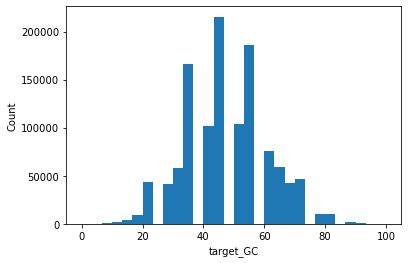

In [11]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

VPS13D
	ENST00000613099.4: 9831 / 16216 probes passed the filter 43 < target_GC <  63.
PRDM2
	ENST00000343137.8: 2957 / 5768 probes passed the filter 43 < target_GC <  63.
LUZP1
	ENST00000418342.5: 5628 / 8392 probes passed the filter 43 < target_GC <  63.
CNR2
	ENST00000374472.4: 3270 / 5225 probes passed the filter 43 < target_GC <  63.
AHDC1
	ENST00000374011.6: 1922 / 6409 probes passed the filter 43 < target_GC <  63.
AGO3
	ENST00000373191.8: 6449 / 19658 probes passed the filter 43 < target_GC <  63.
RAB3B
	ENST00000371655.3: 7044 / 12815 probes passed the filter 43 < target_GC <  63.
USP24
	ENST00000294383.6: 5285 / 10520 probes passed the filter 43 < target_GC <  63.
MAN1A2
	ENST00000356554.7: 2645 / 8547 probes passed the filter 43 < target_GC <  63.
NOTCH2
	ENST00000256646.6: 7147 / 11360 probes passed the filter 43 < target_GC <  63.
TPR
	ENST00000367478.8: 3849 / 9679 probes passed the filter 43 < target_GC <  63.
PLXNA2
	ENST00000367033.3: 7110 / 11415 probes passed the fil

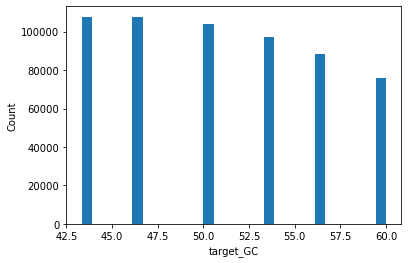

In [12]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=43, upper_bound=63)
plot.plot_hist(probe_dict, column_key='target_GC')

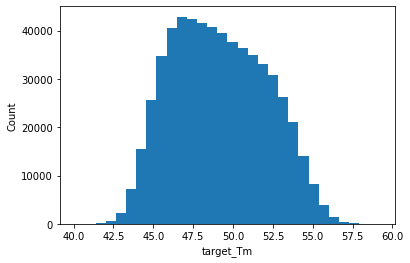

In [13]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=300, fmd_percentile=30, probe_conc=0.05,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

VPS13D
	ENST00000613099.4: 7883 / 9831 probes passed the filter 46 < target_Tm <  56.
PRDM2
	ENST00000343137.8: 2373 / 2957 probes passed the filter 46 < target_Tm <  56.
LUZP1
	ENST00000418342.5: 4775 / 5628 probes passed the filter 46 < target_Tm <  56.
CNR2
	ENST00000374472.4: 2884 / 3270 probes passed the filter 46 < target_Tm <  56.
AHDC1
	ENST00000374011.6: 1852 / 1922 probes passed the filter 46 < target_Tm <  56.
AGO3
	ENST00000373191.8: 5243 / 6449 probes passed the filter 46 < target_Tm <  56.
RAB3B
	ENST00000371655.3: 5606 / 7044 probes passed the filter 46 < target_Tm <  56.
USP24
	ENST00000294383.6: 3926 / 5285 probes passed the filter 46 < target_Tm <  56.
MAN1A2
	ENST00000356554.7: 1997 / 2645 probes passed the filter 46 < target_Tm <  56.
NOTCH2
	ENST00000256646.6: 6021 / 7147 probes passed the filter 46 < target_Tm <  56.
TPR
	ENST00000367478.8: 2423 / 3849 probes passed the filter 46 < target_Tm <  56.
PLXNA2
	ENST00000367033.3: 6364 / 7110 probes passed the filter 46

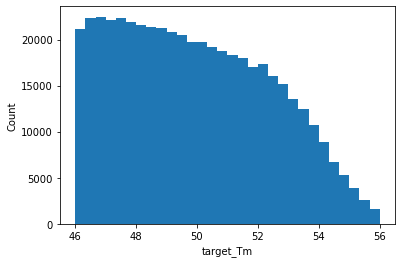

In [14]:
# Filter Tm and plot Tm distribution after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=46, upper_bound=56)
plot.plot_hist(probe_dict, column_key='target_Tm')

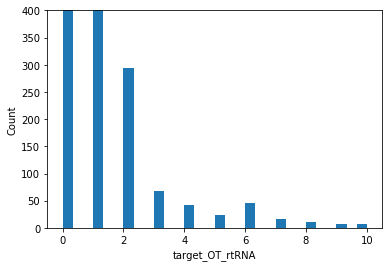

VPS13D
	ENST00000613099.4: 7870 / 7883 probes passed the filter -inf < target_OT_rtRNA <  0.5.
PRDM2
	ENST00000343137.8: 2358 / 2373 probes passed the filter -inf < target_OT_rtRNA <  0.5.
LUZP1
	ENST00000418342.5: 4775 / 4775 probes passed the filter -inf < target_OT_rtRNA <  0.5.
CNR2
	ENST00000374472.4: 2874 / 2884 probes passed the filter -inf < target_OT_rtRNA <  0.5.
AHDC1
	ENST00000374011.6: 1852 / 1852 probes passed the filter -inf < target_OT_rtRNA <  0.5.
AGO3
	ENST00000373191.8: 5178 / 5243 probes passed the filter -inf < target_OT_rtRNA <  0.5.
RAB3B
	ENST00000371655.3: 5599 / 5606 probes passed the filter -inf < target_OT_rtRNA <  0.5.
USP24
	ENST00000294383.6: 3926 / 3926 probes passed the filter -inf < target_OT_rtRNA <  0.5.
MAN1A2
	ENST00000356554.7: 1997 / 1997 probes passed the filter -inf < target_OT_rtRNA <  0.5.
NOTCH2
	ENST00000256646.6: 6021 / 6021 probes passed the filter -inf < target_OT_rtRNA <  0.5.
TPR
	ENST00000367478.8: 2423 / 2423 probes passed the filte

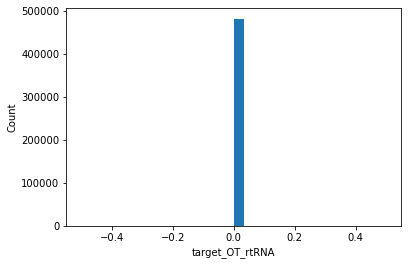

In [15]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
plot.plot_hist(probe_dict, 'target_OT_rtRNA')

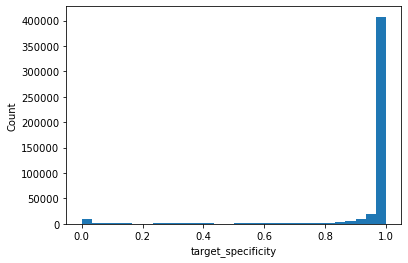

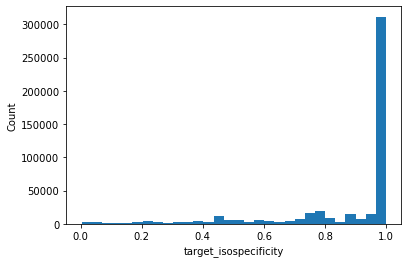

In [16]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

VPS13D
	ENST00000613099.4: 7836 / 7870 probes passed the filter 0.75 < target_specificity <  inf.
PRDM2
	ENST00000343137.8: 2316 / 2358 probes passed the filter 0.75 < target_specificity <  inf.
LUZP1
	ENST00000418342.5: 4775 / 4775 probes passed the filter 0.75 < target_specificity <  inf.
CNR2
	ENST00000374472.4: 2226 / 2874 probes passed the filter 0.75 < target_specificity <  inf.
AHDC1
	ENST00000374011.6: 1844 / 1852 probes passed the filter 0.75 < target_specificity <  inf.
AGO3
	ENST00000373191.8: 3287 / 5178 probes passed the filter 0.75 < target_specificity <  inf.
RAB3B
	ENST00000371655.3: 4901 / 5599 probes passed the filter 0.75 < target_specificity <  inf.
USP24
	ENST00000294383.6: 3915 / 3926 probes passed the filter 0.75 < target_specificity <  inf.
MAN1A2
	ENST00000356554.7: 1997 / 1997 probes passed the filter 0.75 < target_specificity <  inf.
NOTCH2
	ENST00000256646.6: 5602 / 6021 probes passed the filter 0.75 < target_specificity <  inf.
TPR
	ENST00000367478.8: 2396 

	ENST00000521922.5: 2360 / 3698 probes passed the filter 0.75 < target_isospecificity <  inf.
SAMD12
	ENST00000409003.4: 2127 / 2964 probes passed the filter 0.75 < target_isospecificity <  inf.
KLHL9
	ENST00000359039.4: 1305 / 1305 probes passed the filter 0.75 < target_isospecificity <  inf.
TLN1
	ENST00000314888.9: 4295 / 5041 probes passed the filter 0.75 < target_isospecificity <  inf.
ZCCHC6
	ENST00000375963.7: 1406 / 1664 probes passed the filter 0.75 < target_isospecificity <  inf.
TSTD2
	ENST00000341170.4: 1932 / 1932 probes passed the filter 0.75 < target_isospecificity <  inf.
PAPPA
	ENST00000328252.3: 4701 / 5024 probes passed the filter 0.75 < target_isospecificity <  inf.
ZBTB43
	ENST00000373464.4: 2127 / 2173 probes passed the filter 0.75 < target_isospecificity <  inf.
GPR107
	ENST00000372410.7: 2180 / 3374 probes passed the filter 0.75 < target_isospecificity <  inf.
PRRC2B
	ENST00000357304.8: 3680 / 5436 probes passed the filter 0.75 < target_isospecificity <  inf.
GT

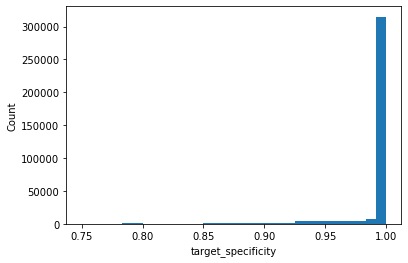

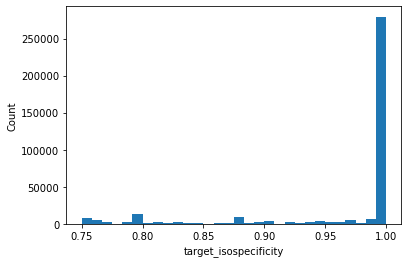

In [17]:
# Filter the specificities and isoform specificities of the target regions
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.75)
filters.filter_probe_dict_by_metric(probe_dict, 'target_isospecificity', lower_bound=0.75)
plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

# Design readout sequences

In [ ]:
# Load the readout sequences into a data frame
readout_seqs = fio.load_fasta_into_df(readout_fasta_file)
rs.append_on_bit_ids_to_readout_sequences(readout_seqs, bit_names)
readout_seqs 

In [ ]:
# Add the readout sequences. Here we randomly add 3 readout sequences to each probe.
# Add an "A" between the concatenated sequences.
rs.add_readout_seqs_to_probes_random(probe_dict, readout_seqs, barcode_table, 3, 
                                     spacer='A', gene_id_key='name', n_threads=8)

In [ ]:
# Filter out probes that have off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_readout_sequence', 'target_readout_OT_rtRNA', 15)
plot.plot_hist(probe_dict, 'target_readout_OT_rtRNA', y_max=400)
filters.filter_probe_dict_by_metric(probe_dict, 'target_readout_OT_rtRNA', upper_bound=0.5)
plot.plot_hist(probe_dict, 'target_readout_OT_rtRNA')

In [ ]:
# NOTE: This step is optional since: 1. JM didn't have this step. 2. It filters out many probes.
# Calculate how many more off-targets to the transcriptome are introduced due to the readout sequences.
# The 
ot.calc_OT_diffs(probe_dict, ottable_transcriptome, 'target_sequence', 'target_readout_sequence', 'readout_OT_increase', 17)
plot.plot_hist(probe_dict, 'readout_OT_increase', y_max=400)
# Filter out the probes with extra off-targets due to the readouts
filters.filter_probe_dict_by_metric(probe_dict, 'readout_OT_increase', upper_bound=0.001)
plot.plot_hist(probe_dict, 'readout_OT_increase')

# Select probes

In [ ]:
%%time
from importlib import reload
reload(ps)
ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=92, N_on_bits=4, N_threads=16)

In [ ]:
probe_dict['VPS13D']['ENST00000613099.4']

In [ ]:
from importlib import reload
reload(ot)
reload(plot)

#probe_dict['VPS13D']['ENST00000613099.4']

In [ ]:

reload(filters)
reload(plot)


#
#plot.plot_gc_content(probe_dict)


#probe_dict['VPS13D']['ENST00000613099.4']

In [ ]:
# Load primers
reload(fio)

forward_primers, reverse_primers = fio.load_primers(forward_primer_file, reverse_primer_file)